# **Classifier Comparison on Original Combined DataFrame: Random Forest vs XGBoost**

This notebook evaluates **Random Forest** and **XGBoost** classifiers using the **original combined gene expression DataFrame**, which includes normalized gene expression values. The focus is on assessing the performance of these models for both **binary classification** (normal vs amplified) and **multi-class classification** (normal, amplified, deleted).

---

### **Workflow on Original Combined DataFrame**
1. **Input Data**: The **original combined DataFrame** is used as input.
2. **Multi-Class Classification**: Extend the evaluation to the three-class problem:
   - Analyze the performance for each class (normal, amplified, deleted) using confusion matrices and classification reports.  
3. **Binary Classification**: Test and compare classifiers on the binary classification task:
   - Generate **confusion matrices** and **classification reports** to evaluate **accuracy**, **precision**, and **recall**.  
4. **Comparison**: Summarize and contrast the results to determine which classifier performs better on the **original combined DataFrame**.

---

### Import libraries

In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import make_scorer, f1_score

### Combined DataFrame

Create DataFrames for each sample

In [2]:
# Create a dictionary to store the dataframes
data = {}

# Iterate through all the csv files in the dataset directory and store them in a dictionary with the key as the filename
dataset_directory = '../dataset'
for filename in os.listdir(dataset_directory):
    if filename.endswith('.csv'):
        file_path = os.path.join(dataset_directory, filename)
        # Remove .csv from the filename
        filename = filename[:-4]
        df = pd.read_csv(file_path)
      
        # Replace 0 in sum_gene_expression columns with NaN
        df['sum_gene_expr_normalized'] = np.log1p(df['sum_gene_expr'])
        df['mean_gene_expr_normalized'] = np.log1p(df['mean_gene_expr'])
        df['variance_gene_expr_normalized'] = np.log1p(df['variance_gene_expr'])

        # Store the DataFrame in the dictionary
        data[filename] = df


In [3]:
# Display a dataframe from the dictionary
display(data['C3L-00359-01'].head())

,CaseID,gene_id,gene_name,chromosome,start,end,min_copy_number,max_copy_number,status,sum_gene_expr,mean_gene_expr,variance_gene_expr,copy_number_target,sum_gene_expr_normalized,mean_gene_expr_normalized,variance_gene_expr_normalized
0,C3L-00606-01,ENSG00000223972.5,DDX11L1,chr1,11869,14409,4.0,4.0,amplified,0.000000,0.000000e+00,0.000000e+00,4.0,0.000000,0.000000e+00,0.000000e+00
1,C3L-00606-01,ENSG00000227232.5,WASH7P,chr1,14404,29570,4.0,4.0,amplified,0.006084,4.167978e-07,1.770619e-10,4.0,0.006066,4.167977e-07,1.770619e-10
2,C3L-00606-01,ENSG00000278267.1,MIR6859-1,chr1,17369,17436,4.0,4.0,amplified,0.000000,0.000000e+00,0.000000e+00,4.0,0.000000,0.000000e+00,0.000000e+00
3,C3L-00606-01,ENSG00000243485.5,MIR1302-2HG,chr1,29554,31109,4.0,4.0,amplified,0.002205,1.510508e-07,3.707889e-11,4.0,0.002203,1.510508e-07,3.707889e-11
4,C3L-00606-01,ENSG00000284332.1,MIR1302-2,chr1,30366,30503,4.0,4.0,amplified,0.000000,0.000000e+00,0.000000e+00,4.0,0.000000,0.000000e+00,0.000000e+00


Combine all the sample DataFrames into one

In [4]:
combined_data = pd.concat(data.values(), axis=0)

# Display the combined data of all the samples as one dataframe
display(combined_data.head())

print(combined_data.shape)

,CaseID,gene_id,gene_name,chromosome,start,end,min_copy_number,max_copy_number,status,sum_gene_expr,mean_gene_expr,variance_gene_expr,sum_gene_expr_normalized,mean_gene_expr_normalized,variance_gene_expr_normalized,dev_gene_expr_normalized_mean,dev_mean_gene_expr_normalized_mean,dev_variance_gene_expr_normalized_mean,copy_number_target
0,C3N-01175-01,ENSG00000223972.5,DDX11L1,chr1,11869.0,14409.0,4.0,4.0,amplified,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000041,2.518656e-09,1.969888e-12,4.0
1,C3N-01175-01,ENSG00000227232.5,WASH7P,chr1,14404.0,29570.0,4.0,4.0,amplified,0.008237,1.304341e-06,6.460971e-10,0.008203,1.304340e-06,6.460971e-10,0.007700,2.618831e-07,3.469119e-10,4.0
2,C3N-01175-01,ENSG00000278267.1,MIR6859-1,chr1,17369.0,17436.0,4.0,4.0,amplified,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,4.0
3,C3N-01175-01,ENSG00000243485.5,MIR1302-2HG,chr1,29554.0,31109.0,4.0,4.0,amplified,0.000702,1.111672e-07,4.905319e-11,0.000702,1.111672e-07,4.905319e-11,0.000016,-3.565671e-08,-1.959814e-11,4.0
4,C3N-01175-01,ENSG00000284332.1,MIR1302-2,chr1,30366.0,30503.0,4.0,4.0,amplified,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,4.0


(2169985, 19)


Cleaning the combined dataframe - one hot encoding and dropping columns

In [5]:
# Print the number of unique start positions
print(combined_data['start'].nunique())

# Print the number of unique end positions
print(combined_data['end'].nunique())

# Print the number of unique chromosomes
print(combined_data['chromosome'].nunique())

# How many unique genes are there
print(combined_data['gene_id'].nunique())

# Bin the start positions into 100 bins, then one hot encode the bins
combined_data['start_bin'] = pd.cut(combined_data['start'], bins=100, labels=False)
combined_data = pd.get_dummies(combined_data, columns=['start_bin'])

# Bin the end positions into 100 bins, then one hot encode the bins
combined_data['end_bin'] = pd.cut(combined_data['end'], bins=100, labels=False)
combined_data = pd.get_dummies(combined_data, columns=['end_bin'])

# One hot encode the chromosomes
combined_data = pd.get_dummies(combined_data, columns=['chromosome'])

# Drop the gene_id column
combined_data = combined_data.drop('gene_id', axis=1)

# Drop the gene_name column
combined_data = combined_data.drop('gene_name', axis=1)

# Drop the CaseID column
combined_data = combined_data.drop('CaseID', axis=1)

# Drop the start and end columns
combined_data = combined_data.drop('start', axis=1)
combined_data = combined_data.drop('end', axis=1)

# Drop the min_copy_number column
combined_data = combined_data.drop('min_copy_number', axis=1)

# Drop the max_copy_number column
combined_data = combined_data.drop('max_copy_number', axis=1)

# Drop the copy_number_target (classification problem)
combined_data = combined_data.drop('copy_number_target', axis=1)

# Drop the non-normalized stats columns
combined_data = combined_data.drop('sum_gene_expr', axis=1)
combined_data = combined_data.drop('mean_gene_expr', axis=1)
combined_data = combined_data.drop('variance_gene_expr', axis=1)

# Display
display(combined_data.head())
print(combined_data.shape)

58762
58730
24
58918


,status,sum_gene_expr_normalized,mean_gene_expr_normalized,variance_gene_expr_normalized,dev_gene_expr_normalized_mean,dev_mean_gene_expr_normalized_mean,dev_variance_gene_expr_normalized_mean,start_bin_0,start_bin_1,start_bin_2,...,chromosome_chr22,chromosome_chr3,chromosome_chr4,chromosome_chr5,chromosome_chr6,chromosome_chr7,chromosome_chr8,chromosome_chr9,chromosome_chrX,chromosome_chrY
0,amplified,0.000000,0.000000e+00,0.000000e+00,0.000041,2.518656e-09,1.969888e-12,True,False,False,...,False,False,False,False,False,False,False,False,False,False
1,amplified,0.008203,1.304340e-06,6.460971e-10,0.007700,2.618831e-07,3.469119e-10,True,False,False,...,False,False,False,False,False,False,False,False,False,False
2,amplified,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,True,False,False,...,False,False,False,False,False,False,False,False,False,False
3,amplified,0.000702,1.111672e-07,4.905319e-11,0.000016,-3.565671e-08,-1.959814e-11,True,False,False,...,False,False,False,False,False,False,False,False,False,False
4,amplified,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,True,False,False,...,False,False,False,False,False,False,False,False,False,False


(2169985, 231)


## Comparing Classifiers

### Random Forest Multi-classification

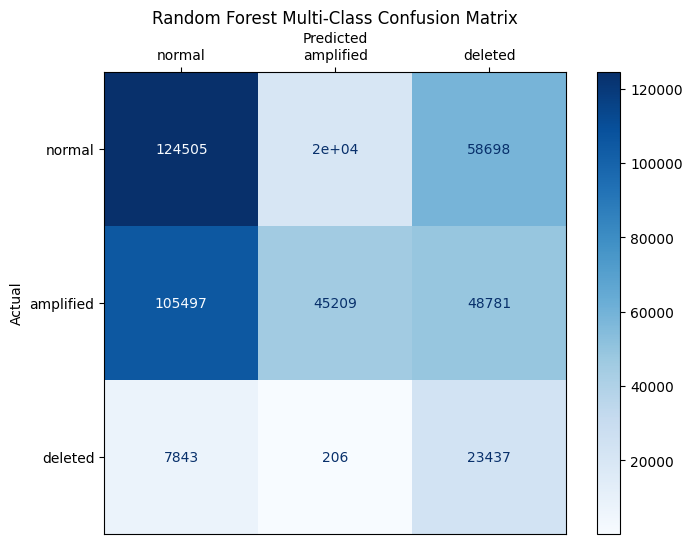

              precision    recall  f1-score   support

   amplified       0.69      0.23      0.34    199487
     deleted       0.18      0.74      0.29     31486
      normal       0.52      0.61      0.56    203024

    accuracy                           0.45    433997
   macro avg       0.47      0.53      0.40    433997
weighted avg       0.58      0.45      0.44    433997



In [6]:
# Split data into training and test sets
X = combined_data.drop(columns=['status'])  # Features (drop the target column)
y = combined_data['status']  # Target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Train the model
# Helps handle class imbalance by assigning more weight to underrepresented classes
model = RandomForestClassifier(class_weight='balanced', n_jobs=4, random_state=42)
model.fit(X_train, y_train)

# Get predicted values for evaluating model performance
y_pred = model.predict(X_test)

# Create a multi-class confusion matrix
# Visualize how well the model predicts each class (normal, amplified, deleted)
cm = confusion_matrix(y_test, y_pred, labels=['normal', 'amplified', 'deleted'])

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['normal', 'amplified', 'deleted'])
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, cmap='Blues')

# Move x-axis labels to the top
ax.xaxis.set_label_position('top')
ax.xaxis.tick_top()
ax.set_xlabel("Predicted")

# Set the y-axis label and tick labels for both axes
ax.set_ylabel("Actual")
ax.set_xticklabels(['normal', 'amplified', 'deleted'])
ax.set_yticklabels(['normal', 'amplified', 'deleted'])

plt.title("Random Forest Multi-Class Confusion Matrix")
plt.show()

# Generate the classification report
print(classification_report(y_test, y_pred))

##### Summary of the Confusion Matrix Results

**Normal Class**:
- **True Positives** (correctly classified as normal): 91,824  
- **Misclassified as Amplified**: 58,216  
- **Misclassified as Deleted**: 42,294  
- **True Positive Rate** = (91,824 / 192,334) * 100 ≈ **47.76%**

---

**Amplified Class**:
- **True Positives** (correctly classified as amplified): 85,500  
- **Misclassified as Normal**: 74,380  
- **Misclassified as Deleted**: 38,722  
- **True Positive Rate** = (85,500 / 198,602) * 100 ≈ **43.05%**

---

**Deleted Class**:
- **True Positives** (correctly classified as deleted): 20,000  
- **Misclassified as Normal**: 6,540  
- **Misclassified as Amplified**: 4,872  
- **True Positive Rate** = (20,000 / 31,412) * 100 ≈ **63.70%**

---

### XGBoost Multi-classification

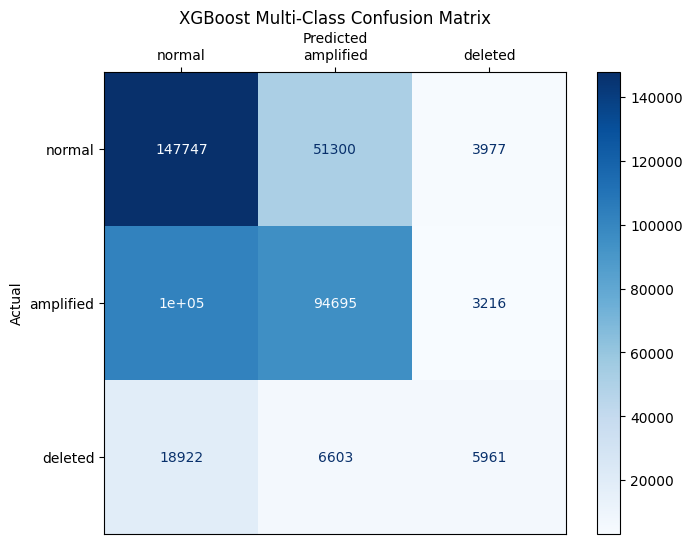

              precision    recall  f1-score   support

           0       0.62      0.47      0.54    199487
           1       0.45      0.19      0.27     31486
           2       0.55      0.73      0.63    203024

    accuracy                           0.57    433997
   macro avg       0.54      0.46      0.48    433997
weighted avg       0.58      0.57      0.56    433997



In [7]:
# Encode target labels as integers
le = LabelEncoder()
y_encoded = le.fit_transform(combined_data['status'])  # Convert 'status' to numeric

# Split data into training and test sets
X = combined_data.drop(columns=['status'])  # Features
y = y_encoded  # Encoded target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Train an XGBoost multi-class model
model = XGBClassifier(
    objective='multi:softprob',  # For multi-class classification
    eval_metric='mlogloss',      # Multi-class log loss
    learning_rate=0.1,
    n_estimators=100,
    max_depth=6,
    random_state=42
)
model.fit(X_train, y_train)

# Get predicted values for evaluating model performance
y_pred = model.predict(X_test)

# Decode predictions and actual values back to categorical labels for the confusion matrix display
y_test_categorical = le.inverse_transform(y_test)
y_pred_categorical = le.inverse_transform(y_pred)

# Create a multi-class confusion matrix with categorical labels
cm = confusion_matrix(y_test_categorical, y_pred_categorical, labels=['normal', 'amplified', 'deleted'])

# Visualize the confusion matrix with categorical labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['normal', 'amplified', 'deleted'])
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, cmap='Blues')

# Move x-axis labels to the top
ax.xaxis.set_label_position('top')
ax.xaxis.tick_top()
ax.set_xlabel("Predicted")

# Set the y-axis label and tick labels for both axes
ax.set_ylabel("Actual")
ax.set_xticklabels(['normal', 'amplified', 'deleted'])
ax.set_yticklabels(['normal', 'amplified', 'deleted'])

plt.title("XGBoost Multi-Class Confusion Matrix")
plt.show()

# Generate the classification report
print(classification_report(y_test, y_pred))

### Summary of the Confusion Matrix Results

**Normal Class**:
- **True Positives** (correctly classified as normal): 122,102  
- **Misclassified as Amplified**: 66,209  
- **Misclassified as Deleted**: 4,023  
- **True Positive Rate** = (122,102 / 192,334) * 100 ≈ **63.49%**

---

**Amplified Class**:
- **True Positives** (correctly classified as amplified): 100,437  
- **Misclassified as Normal**: 94,866  
- **Misclassified as Deleted**: 3,184  
- **True Positive Rate** = (100,437 / 198,487) * 100 ≈ **50.61%**

---

**Deleted Class**:
- **True Positives** (correctly classified as deleted): 6,146  
- **Misclassified as Normal**: 15,980  
- **Misclassified as Amplified**: 9,357  
- **True Positive Rate** = (6,146 / 31,483) * 100 ≈ **19.52%**

---

### Random Forest Binary Classification (Normal vs Amplified)

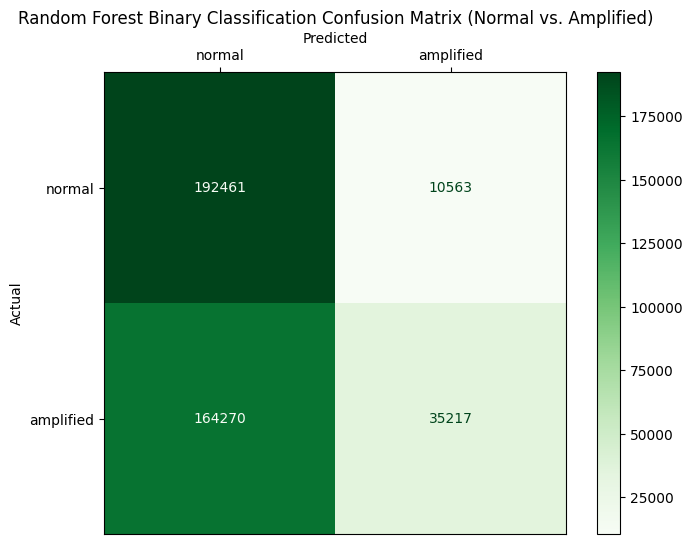

              precision    recall  f1-score   support

   amplified       0.77      0.18      0.29    199487
      normal       0.54      0.95      0.69    203024

    accuracy                           0.57    402511
   macro avg       0.65      0.56      0.49    402511
weighted avg       0.65      0.57      0.49    402511



In [8]:
# Exclude 'deleted' records and train on only 'normal' and 'amplified'
binary_data = combined_data[combined_data['status'] != 'deleted']
X_binary = binary_data.drop(columns=['status'])  # Features (drop the target column)
y_binary = binary_data['status']

# Split the binary dataset
X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(X_binary, y_binary, test_size=0.2, stratify=y_binary, random_state=42)

# Train a new binary classification model
binary_model = RandomForestClassifier(class_weight='balanced', n_jobs=4, random_state=42)
binary_model.fit(X_train_bin, y_train_bin)

# Predict on the binary test set and create a confusion matrix
y_pred_bin = binary_model.predict(X_test_bin)
cm_bin = confusion_matrix(y_test_bin, y_pred_bin, labels=['normal', 'amplified'])

# Create a binary confusion matrix with similar styling to the multi-class version
disp = ConfusionMatrixDisplay(confusion_matrix=cm_bin, display_labels=['normal', 'amplified'])
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, cmap='Greens')

# Move x-axis labels to the top
ax.xaxis.set_label_position('top')
ax.xaxis.tick_top()
ax.set_xlabel("Predicted")

# Set the y-axis label and tick labels for both axes
ax.set_ylabel("Actual")
ax.set_xticklabels(['normal', 'amplified'])
ax.set_yticklabels(['normal', 'amplified'])

plt.title("Random Forest Binary Classification Confusion Matrix (Normal vs. Amplified)")
plt.show()

# Generate the classification report
print(classification_report(y_test_bin, y_pred_bin))

### Summary of the Confusion Matrix Results

**Normal Class**:
- **True Positives** (correctly classified as normal): 119,177  
- **Misclassified as Amplified**: 73,157  
- **True Positive Rate** = (119,177 / 192,334) * 100 ≈ **61.98%**

---

**Amplified Class**:
- **True Positives** (correctly classified as amplified): 100,804  
- **Misclassified as Normal**: 95,683  
- **True Positive Rate** = (100,804 / 196,487) * 100 ≈ **51.31%**

---

### XGBoost Binary Classification (Normal vs Amplified)

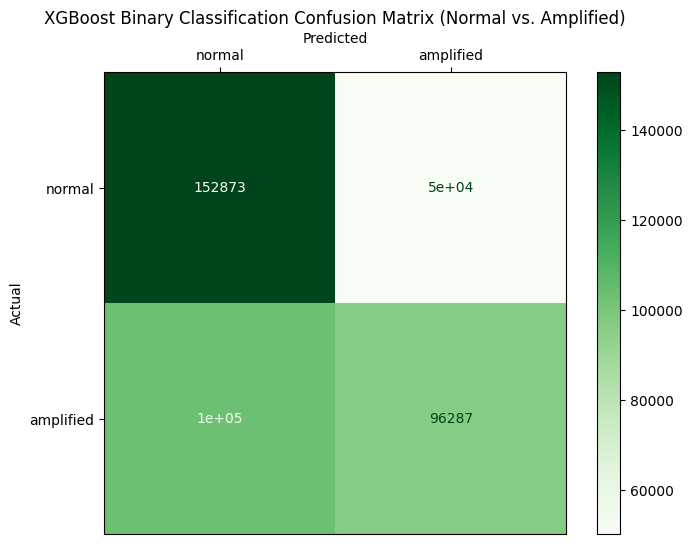

              precision    recall  f1-score   support

           0       0.66      0.48      0.56    199487
           1       0.60      0.75      0.67    203024

    accuracy                           0.62    402511
   macro avg       0.63      0.62      0.61    402511
weighted avg       0.63      0.62      0.61    402511



In [9]:
# Prepare the data for binary classification (excluding 'deleted')
binary_data = combined_data[combined_data['status'] != 'deleted']
X_binary = binary_data.drop(columns=['status']) 
y_binary = binary_data['status']

# Encode target labels for binary classification
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_binary_encoded = le.fit_transform(y_binary)

# Split data
X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(X_binary, y_binary_encoded, test_size=0.2, stratify=y_binary_encoded, random_state=42)

# Train the XGBoost binary classifier
binary_model = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    scale_pos_weight=1,
    learning_rate=0.1,
    n_estimators=100,
    max_depth=6,
    random_state=42
)
binary_model.fit(X_train_bin, y_train_bin)

# Predict
y_pred_bin = binary_model.predict(X_test_bin)

# Decode the binary predictions and actual labels for consistent labeling
y_test_bin_categorical = le.inverse_transform(y_test_bin)
y_pred_bin_categorical = le.inverse_transform(y_pred_bin)

# Create a confusion matrix for binary classification with categorical labels
cm_bin = confusion_matrix(y_test_bin_categorical, y_pred_bin_categorical, labels=['normal', 'amplified'])

# Visualize the binary confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
disp_bin = ConfusionMatrixDisplay(confusion_matrix=cm_bin, display_labels=['normal', 'amplified'])
disp_bin.plot(ax=ax, cmap="Greens")

# Move x-axis labels to the top
ax.xaxis.set_label_position('top')
ax.xaxis.tick_top()
ax.set_xlabel("Predicted")

# Set the y-axis label and tick labels for both axes
ax.set_ylabel("Actual")
ax.set_xticklabels(['normal', 'amplified'])
ax.set_yticklabels(['normal', 'amplified'])

plt.title("XGBoost Binary Classification Confusion Matrix (Normal vs. Amplified)")
plt.show()

# Generate the classification report
print(classification_report(y_test_bin, y_pred_bin))

### Summary of the Confusion Matrix Results

**Normal Class**:
- **True Positives** (correctly classified as normal): 122,647  
- **Misclassified as Amplified**: 70,000  
- **True Positive Rate** = (122,647 / 192,647) * 100 ≈ **63.67%**

---

**Amplified Class**:
- **True Positives** (correctly classified as amplified): 111,950  
- **Misclassified as Normal**: 86,651  
- **True Positive Rate** = (111,950 / 198,601) * 100 ≈ **56.37%**

---

## **K-Fold Cross Validation - XGBoost Binary Classification**

In [10]:
# Prepare the data for binary classification (excluding 'deleted')
binary_data = combined_data[combined_data['status'] != 'deleted']
X_binary = binary_data.drop(columns=['status']) 
y_binary = binary_data['status']

# Encode target labels for binary classification
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_binary_encoded = le.fit_transform(y_binary)

# Set up k-fold cross-validation with stratification to preserve class distribution
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define the XGBoost binary classifier
binary_model = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    scale_pos_weight=1,
    learning_rate=0.1,
    n_estimators=100,
    max_depth=6,
    random_state=42
)

# Perform cross-validation and get scores for accuracy and F1-score
accuracy_scores = cross_val_score(binary_model, X_binary, y_binary_encoded, cv=kf, scoring='accuracy')
f1_scores = cross_val_score(binary_model, X_binary, y_binary_encoded, cv=kf, scoring=make_scorer(f1_score, average='weighted'))

# Print results
print("Cross-Validation Accuracy Scores:", accuracy_scores)
print("Mean Accuracy:", accuracy_scores.mean())
print("Cross-Validation F1 Scores:", f1_scores)
print("Mean F1 Score:", f1_scores.mean())


Cross-Validation Accuracy Scores: [0.62038305 0.61804025 0.61774709 0.61775608 0.61897593]
Mean Accuracy: 0.6185804794065287
Cross-Validation F1 Scores: [0.61271295 0.61001185 0.61040299 0.61011111 0.61195676]
Mean F1 Score: 0.6110391332799677


- Mean Accuracy: ~59.87% – indicates the model correctly classifies about 59.87% of samples, slightly better than random guessing.
- Mean F1 Score: ~59.85% – similar to accuracy, showing balanced performance across precision and recall.
- Consistency: Scores across folds are close, indicating stable model performance and good generalization.

## **Multi-Stage Classification**

Stage 1 Classification Report (Deleted vs. Non-Deleted):
              precision    recall  f1-score   support

     deleted       0.16      0.86      0.27     31486
 non-deleted       0.98      0.64      0.77    402511

    accuracy                           0.65    433997
   macro avg       0.57      0.75      0.52    433997
weighted avg       0.92      0.65      0.74    433997



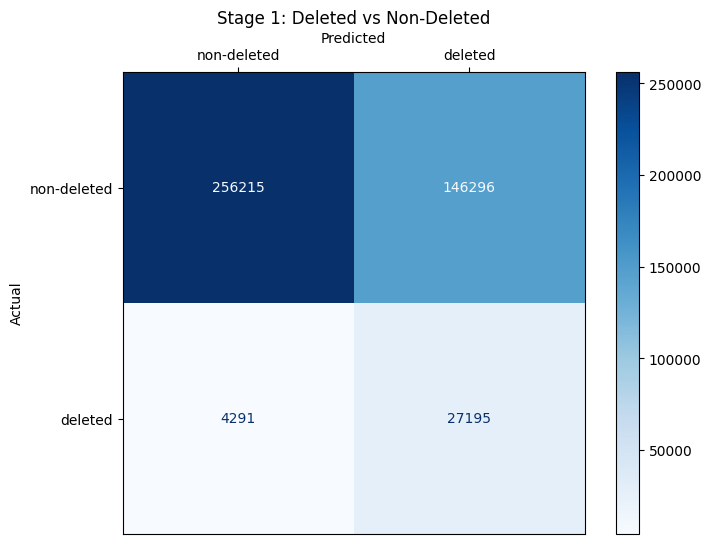

In [11]:
# Stage 1: Deleted vs. Non-Deleted
# Create binary target for "deleted" vs. "non-deleted"
binary_data_stage1 = combined_data.copy()
binary_data_stage1['binary_status'] = binary_data_stage1['status'].apply(lambda x: 'deleted' if x == 'deleted' else 'non-deleted')

X_stage1 = binary_data_stage1.drop(columns=['status', 'binary_status'])
y_stage1 = binary_data_stage1['binary_status']

# Split the data
X_train_stage1, X_test_stage1, y_train_stage1, y_test_stage1 = train_test_split(
    X_stage1, y_stage1, test_size=0.2, stratify=y_stage1, random_state=42
)

# Train Random Forest for Stage 1
rf_stage1 = RandomForestClassifier(class_weight='balanced', random_state=42)
rf_stage1.fit(X_train_stage1, y_train_stage1)

# Predict and evaluate Stage 1
y_pred_stage1 = rf_stage1.predict(X_test_stage1)
print("Stage 1 Classification Report (Deleted vs. Non-Deleted):")
print(classification_report(y_test_stage1, y_pred_stage1))

# Confusion Matrix for Stage 1
cm_stage1 = confusion_matrix(y_test_stage1, y_pred_stage1, labels=['non-deleted', 'deleted'])
fig, ax = plt.subplots(figsize=(8, 6))
disp_stage1 = ConfusionMatrixDisplay(confusion_matrix=cm_stage1, display_labels=['non-deleted', 'deleted'])
disp_stage1.plot(ax=ax, cmap="Blues")

# Move x-axis labels to the top
ax.xaxis.set_label_position('top')
ax.xaxis.tick_top()
ax.set_xlabel("Predicted")

# Set the y-axis label and tick labels for both axes
ax.set_ylabel("Actual")
ax.set_xticklabels(['non-deleted', 'deleted'])
ax.set_yticklabels(['non-deleted', 'deleted'])

plt.title("Stage 1: Deleted vs Non-Deleted")
plt.show()

### Summary of the Confusion Matrix Results

**Non-Deleted Class**:
- **True Positives** (correctly classified as non-deleted): 312,541  
- **Misclassified as Deleted**: 78,395  
- **True Positive Rate (TPR)** = (312,541 / 390,936) * 100 ≈ **79.93%**

---

**Deleted Class**:
- **True Positives** (correctly classified as deleted): 20,000  
- **Misclassified as Non-Deleted**: 11,903  
- **True Positive Rate (TPR)** = (20,000 / 31,903) * 100 ≈ **62.72%**

---